# Tutorial 12-2: The Artist – "Building DDPM for MNIST"

**Course:** CSEN 342: Deep Learning  
**Topic:** DDPM, U-Net Architecture, and Image Generation

## Objective
In the previous tutorial, we diffused simple 2D points. Now, we will generate images.

We will implement the **Denoising Diffusion Probabilistic Model (DDPM)** as introduced by Ho et al. (2020). We will train a **U-Net** to reverse the noise process on the **MNIST** dataset.

**The Workflow:**
1.  **Schedule:** Define how much noise to add at each step $t$.
2.  **U-Net:** Build a neural network that takes a noisy image and time $t$ and outputs the noise.
3.  **Train:** Optimize the MSE between real noise and predicted noise.
4.  **Sample:** Start with random static and carve out a digit by removing noise iteratively.

---

## Part 1: The Noise Schedule

We need to pre-calculate the constants for the diffusion process.
Key variables:
* $\beta_t$: Variance schedule (how much noise to add).
* $\alpha_t = 1 - \beta_t$
* $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$ (Cumulative product, allows jumping to step $t$).

We use a linear schedule for $\beta_t$ from $10^{-4}$ to $0.02$.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)
        
        # Register constants as buffers (so they are saved with the model but not trained)
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)
            
        self.n_T = n_T
        self.device = device
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        """
        Training Step: 
        1. Sample random t
        2. Add noise to x to get x_t
        3. Predict noise using nn_model
        4. Return MSE loss
        """
        _ts = torch.randint(1, self.n_T+1, (x.shape[0],), device=self.device)  # t ~ Uniform(1, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)
        
        # x_t = sqrt(alpha_bar) * x_0 + sqrt(1 - alpha_bar) * eps
        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )

        # Predict noise. We pass t / n_T to normalize time input to [0, 1]
        return self.loss_mse(noise, self.nn_model(x_t, (_ts / self.n_T).view(-1, 1), c))

    def sample(self, n_sample, size, device, guide_w=0.0):
        # Start from pure noise
        x_i = torch.randn(n_sample, *size).to(device)
        c_i = torch.arange(0, 10).to(device) # Generate digits 0-9
        c_i = c_i.repeat(n_sample // 10 + 1)[:n_sample]
        
        context_mask = torch.zeros_like(c_i).to(device)
        
        # Iterate backwards: T -> 1
        for i in range(self.n_T, 0, -1):
            t_is = torch.tensor([i / self.n_T]).to(device).repeat(n_sample, 1)
            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # Predict noise
            eps = self.nn_model(x_i, t_is, c_i)
            
            # Update x_{t-1}
            # x_{t-1} = 1/sqrt(alpha_t) * (x_t - (1-alpha_t)/sqrt(1-alpha_bar_t) * eps) + sigma_t * z
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            
        return x_i

def ddpm_schedules(beta1, beta2, T):
    """
    Returns pre-computed schedule constants
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

---

## Part 2: The U-Net

We build a simplified U-Net for MNIST ($28 \times 28$).
* **Input:** Image ($1 \times 28 \times 28$) + Time Embedding + Class Label (for conditioning).
* **Downsample:** Conv $	o$ Conv $	o$ MaxPool.
* **Upsample:** UpConv $	o$ Concat (Skip Connection) $	o$ Conv.
* **Time Embedding:** A dense vector injected at each block so the network knows "how noisy" the image is.

In [2]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, c_emb_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.mlp = nn.Linear(time_emb_dim + c_emb_dim, out_channels)

    def forward(self, x, t_emb, c_emb):
        # Inject Time and Class embeddings
        # We project embeddings to match the number of channels and add them
        emb = self.mlp(torch.cat((t_emb, c_emb), dim=1))
        emb = emb.view(emb.shape[0], emb.shape[1], 1, 1)
        
        out = self.conv(x) + emb
        return out

class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=10, time_emb_dim=32, c_emb_dim=32):
        super().__init__()
        
        # Time Embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.GELU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )
        
        # Class Embedding
        self.c_emb = nn.Embedding(n_classes, c_emb_dim)
        
        # Encoder
        self.down1 = CNNBlock(in_channels, 64, time_emb_dim, c_emb_dim)
        self.down2 = CNNBlock(64, 128, time_emb_dim, c_emb_dim)
        self.pool = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bot = CNNBlock(128, 256, time_emb_dim, c_emb_dim)
        
        # Decoder
        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.up_block1 = CNNBlock(256, 128, time_emb_dim, c_emb_dim) # 256 due to concat
        
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.up_block2 = CNNBlock(128, 64, time_emb_dim, c_emb_dim)
        
        self.out = nn.Conv2d(64, in_channels, 1)

    def forward(self, x, t, c):
        t_emb = self.time_mlp(t)
        c_emb = self.c_emb(c)
        
        # Down
        x1 = self.down1(x, t_emb, c_emb) # 28x28 -> 28x28
        x2 = self.pool(x1)
        x2 = self.down2(x2, t_emb, c_emb) # 14x14 -> 14x14
        x3 = self.pool(x2)
        
        # Bottom
        x3 = self.bot(x3, t_emb, c_emb)   # 7x7 -> 7x7
        
        # Up
        x_up1 = self.up1(x3)
        # Skip Connection: Concat x2
        x_up1 = torch.cat((x2, x_up1), dim=1)
        x_up1 = self.up_block1(x_up1, t_emb, c_emb)
        
        x_up2 = self.up2(x_up1)
        # Skip Connection: Concat x1
        x_up2 = torch.cat((x1, x_up2), dim=1)
        x_up2 = self.up_block2(x_up2, t_emb, c_emb)
        
        return self.out(x_up2)

---

## Part 3: Training

We train for a few epochs. We use `n_T=800` timesteps.

In [4]:
# Config
n_T = 800
lr = 1e-4
epochs = 5
batch_size = 128

# Data
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root='../data', train=True, transform=tf, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Model
unet = SimpleUNet()
ddpm = DDPM(nn_model=unet, betas=(1e-4, 0.02), n_T=n_T, device=device)
ddpm.to(device)
optimizer = torch.optim.Adam(ddpm.parameters(), lr=lr)

print("Starting Training...")

for epoch in range(epochs):
    ddpm.train()
    total_loss = 0
    
    for x, c in dataloader:
        x, c = x.to(device), c.to(device)
        optimizer.zero_grad()
        loss = ddpm(x, c)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{epochs} Loss: {avg_loss:.4f}")

Starting Training...
Epoch 1/5 Loss: 0.1063
Epoch 2/5 Loss: 0.0538
Epoch 3/5 Loss: 0.0462
Epoch 4/5 Loss: 0.0422
Epoch 5/5 Loss: 0.0394


## Part 4: Sampling (Generation)

Now the fun part. We ask the model to generate digits.
Since we conditioned on `c` (class labels), we can ask for specific digits!

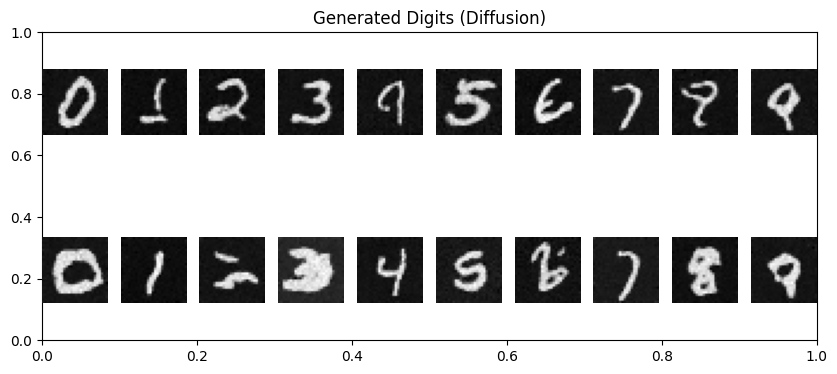

In [5]:
ddpm.eval()
with torch.no_grad():
    # Generate 20 images (2 of each digit 0-9)
    x_gen = ddpm.sample(20, (1, 28, 28), device)

# Plot
plt.figure(figsize=(10, 4))
plt.title("Generated Digits (Diffusion)")
grid_img = x_gen.cpu().view(-1, 28, 28)
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(grid_img[i], cmap='gray')
    plt.axis('off')
plt.show()

### Conclusion

You have built a generative model that outperforms GANs in stability and diversity.

**Why U-Net?** Because the noise $\epsilon$ has the exact same spatial dimensions as the image. The U-Net is efficient at processing multiscale features while maintaining the output resolution.

**Why Time Embeddings?** At $t=1$, the image is clean; the network needs to make tiny adjustments. At $t=400$, the image is noise; the network needs to hallucinate structure. The embedding tells the network which "mode" to operate in.